In [47]:
import pandas as pd
import numpy as np
import statsmodels.api as sm


In [ ]:

# ========= 1) 读入数据 =========
crsp = pd.read_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/crsp_daily_extended.csv')
ff5  = pd.read_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/FF5_extended.csv')
# After loading ff5, rename columns to match expected names
ff5 = ff5.rename(columns={
    'mktrf': 'MKT_RF',
    'smb': 'SMB',
    'hml': 'HML',
    'rmw': 'RMW',
    'cma': 'CMA',
    'rf': 'RF'
})
# 假设 crsp 包含：['permno','date','ret'] (日收益，含股息再投资) 
# ff5 包含：['date','MKT_RF','SMB','HML','RMW','CMA','RF']
# date 格式：YYYYMMDD 或 YYYY-MM-DD

# 统一日期格式
for df in [crsp, ff5]:
    df['date'] = pd.to_datetime(df['date'])

def detect_columns(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None


# ========= 2) 合并收益与因子 =========
df = crsp.merge(ff5, on='date', how='inner')
df['RET'] = pd.to_numeric(df['RET'], errors='coerce')  # Convert RET to numeric, coercing strings to NaN
df['RF'] = pd.to_numeric(df['RF'], errors='coerce')     # Ensure RF is numeric (usually already is)
df['excess_ret'] = df['RET'] - df['RF']   # 超额收益

# Detect and rename the ticker column
ticker_col = detect_columns(df, ['TICKER', 'ticker', 'Ticker', 'symbol', 'permno'])
if ticker_col:
    df = df.rename(columns={ticker_col: 'ticker'})
else:
    raise ValueError("No ticker column found in df. Check df.columns.")


# ========= 3) 定义窗口 =========
# 主事件日 = press release
pr_meta = pd.read_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/press_releases_meta.csv')
call_meta = pd.read_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/earning_call_meta.csv')

events_pr = pr_meta[['ticker','filingDate']].rename(columns={'filingDate':'event_date'})
events_pr['event_type'] = 'press_release'

# 备选事件日 = call
events_call = call_meta[['Ticker','DateTime']].rename(columns={'DateTime':'event_date'})
events_call['event_type'] = 'earnings_call'

# 合并（取需要的）
events = pd.concat([events_pr, events_call], ignore_index=True)
events['event_date'] = pd.to_datetime(events['event_date'], format='mixed')
events['ticker'] = events['ticker'].fillna(events['Ticker'])
events = events.drop(columns=['Ticker'])

# 估计期 [-252,-30], 事件窗举例 [0,+1]
est_win = (-252, -30)
evt_wins = {'m01p01':(-1,1), '0p1':(0,1), '0p2':(0,2)}

/var/folders/rz/k6n0mj6j3xb2f99r3dqnqjbc0000gn/T/ipykernel_54294/606133807.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  crsp = pd.read_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/crsp_daily_extended.csv')


In [72]:
# Count non-missing returns by ticker
ticker_counts = df.groupby('ticker').apply(lambda x: x['RET'].notna().sum())
valid_tickers = ticker_counts[ticker_counts > 100].index.tolist()
print(f"Tickers with sufficient data: {len(valid_tickers)} out of {df['ticker'].nunique()}")

# Filter the merged dataframe to only include tickers with sufficient data
df_filtered = df[df['ticker'].isin(valid_tickers)].copy()

# Also filter the events dataframe to avoid processing events for invalid tickers
events_filtered = events[events['ticker'].isin(valid_tickers)].copy()

print(f"Filtered df: {len(df_filtered)} rows vs. original {len(df)} rows")
print(f"Filtered events: {len(events_filtered)} events vs. original {len(events)} events")

# Replace the original dataframes if you want to use the filtered versions going forward
df = df_filtered
events = events_filtered

Tickers with sufficient data: 528 out of 531
Filtered df: 575792 rows vs. original 576312 rows
Filtered events: 6059 events vs. original 6136 events


/var/folders/rz/k6n0mj6j3xb2f99r3dqnqjbc0000gn/T/ipykernel_54294/3625588254.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ticker_counts = df.groupby('ticker').apply(lambda x: x['RET'].notna().sum())


In [84]:
# ========= 4) 函数：估计alpha/beta & 算CAR =========

def calc_car(ticker, event_date, debug=True):
    out = {}
    dfe = df[df['ticker']==ticker].copy()
    if dfe.empty: 
        if debug: print(f"No data found for ticker {ticker}")
        return None
    
    # 估计期
    est_start = event_date + np.timedelta64(est_win[0],'D')
    est_end   = event_date + np.timedelta64(est_win[1],'D')
    est_data  = dfe[(dfe['date']>=est_start)&(dfe['date']<=est_end)]
    
    if debug: print(f"Estimation period: {est_start} to {est_end}, {len(est_data)} data points")
    
    if len(est_data) < 50:  # 太少不估计
        if debug: print(f"Not enough data points in estimation window: {len(est_data)} < 50")
        return None
    
    # Check for missing or zero values in returns
    if debug:
        missing_ret = est_data['RET'].isna().sum()
        zero_ret = (est_data['RET'] == 0).sum()
        print(f"Missing returns: {missing_ret}, Zero returns: {zero_ret}")
        print(f"Mean excess return: {est_data['excess_ret'].mean():.6f}")
    
    # FF5 回归
    X = est_data[['MKT_RF','SMB','HML','RMW','CMA']]
    y = est_data['excess_ret']
    
    # Drop NaNs from both X and y to ensure they are aligned
    valid_idx = y.notna() & X.notna().all(axis=1)
    y = y[valid_idx]
    X = X[valid_idx]

    # Check if there's enough data left after dropping NaNs
    if len(y) < 50:
        if debug: print(f"Not enough valid data points for regression after dropping NaNs: {len(y)} < 50")
        return None

    X = sm.add_constant(X)
    res = sm.OLS(y, X).fit() # No need for missing='drop' anymore
    coefs = res.params
    
    if debug: 
        print("\nRegression coefficients:")
        print(coefs)
        print(f"R-squared: {res.rsquared:.4f}")
        
    # 各事件窗CAR
    for tag,(lo,hi) in evt_wins.items():
        evt_data = dfe[(dfe['date']>=event_date+np.timedelta64(lo,'D'))&
                       (dfe['date']<=event_date+np.timedelta64(hi,'D'))].copy()
        
        if debug:
            print(f"\nEvent window {tag} ({lo},{hi}): {len(evt_data)} data points")
            if not evt_data.empty:
                print(f"Event dates: {evt_data['date'].min()} to {evt_data['date'].max()}")
        
        # Check if the dataframe is empty or if all returns are NaN
        if evt_data.empty or evt_data['excess_ret'].isna().all():
            if debug and not evt_data.empty: 
                print("All returns are NaN in event window - setting CAR to NaN")
            out[tag] = np.nan
            continue
            
        # Select only the factors that were used in the regression
        factor_cols = list(coefs.index[1:])  # Exclude 'const'
        X_evt = evt_data[factor_cols]
        X_evt = sm.add_constant(X_evt)
        exp_ret = (X_evt * coefs).sum(axis=1)
        evt_data['ar'] = evt_data['excess_ret'] - exp_ret
        
        if debug:
            print("Event window data (first 3 rows):")
            print(evt_data[['date', 'RET', 'excess_ret']].head(3))
            print(f"Mean expected return: {exp_ret.mean():.6f}")
            print(f"Mean abnormal return: {evt_data['ar'].mean():.6f}")
            print(f"Sum abnormal return (CAR): {evt_data['ar'].sum():.6f}")
        
        out[tag] = evt_data['ar'].sum()

    out['ticker'] = ticker
    out['event_date'] = event_date
    return out

# Find an event with complete return data
# Look for events in a time period where you have actual returns (e.g., 2022-2023)
past_events = events[events['event_date'] < '2024-01-01']
if not past_events.empty:
    test_event = past_events.iloc[0]
    print(f"Testing with past event: {test_event['ticker']} on {test_event['event_date']}")
    result = calc_car(test_event['ticker'], test_event['event_date'])
    print("\nResult with historical data:", result)

Testing with past event: A on 2023-11-20 00:00:00
Estimation period: 2023-03-13 00:00:00 to 2023-10-21 00:00:00, 155 data points
Missing returns: 0, Zero returns: 0
Mean excess return: -0.001435

Regression coefficients:
const    -0.001083
MKT_RF    0.995999
SMB       0.196358
HML      -0.064666
RMW      -0.175598
CMA       0.676599
dtype: float64
R-squared: 0.2483

Event window m01p01 (-1,1): 2 data points
Event dates: 2023-11-20 00:00:00 to 2023-11-21 00:00:00
Event window data (first 3 rows):
          date       RET  excess_ret
473 2023-11-20  0.007335    0.007125
474 2023-11-21  0.087208    0.086998
Mean expected return: -0.001004
Mean abnormal return: 0.048066
Sum abnormal return (CAR): 0.096131

Event window 0p1 (0,1): 2 data points
Event dates: 2023-11-20 00:00:00 to 2023-11-21 00:00:00
Event window data (first 3 rows):
          date       RET  excess_ret
473 2023-11-20  0.007335    0.007125
474 2023-11-21  0.087208    0.086998
Mean expected return: -0.001004
Mean abnormal ret

In [85]:
# ========= 5) 跑所有事件 =========
from tqdm.auto import tqdm  # Import tqdm

# Add a progress bar to the loop
results = []
for i,row in tqdm(events.iterrows(), total=len(events), desc="Calculating CARs"):
    # Set debug=False to keep the progress bar clean
    tmp = calc_car(row['ticker'], row['event_date'], debug=False)
    if tmp: results.append(tmp)

cars_ff5 = pd.DataFrame(results)



'''# ========= 6) 合并到主分析表 =========
# 根据 ticker+季度对齐
cars_ff5['fiscal_quarter'] = pd.PeriodIndex(cars_ff5['event_date'], freq='Q').astype(str)
'''

/opt/miniconda3/envs/NLP/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Calculating CARs: 100%|██████████| 6059/6059 [04:55<00:00, 20.52it/s]


"# ========= 6) 合并到主分析表 =========\n# 根据 ticker+季度对齐\ncars_ff5['fiscal_quarter'] = pd.PeriodIndex(cars_ff5['event_date'], freq='Q').astype(str)\n"

In [87]:
cars_ff5

,m01p01,0p1,0p2,ticker,event_date
0,NaN,NaN,NaN,A,2025-05-28 00:00:00
1,NaN,NaN,NaN,A,2025-02-26 00:00:00
2,-0.000359,-0.000359,0.028132,A,2024-11-25 00:00:00
3,0.012064,0.006878,-0.013348,A,2024-08-21 00:00:00
4,-0.123980,-0.115951,-0.135785,A,2024-05-29 00:00:00
...,...,...,...,...,...
5289,-0.027447,0.024751,0.024751,ACN,2023-09-28 08:00:00
5290,-0.053593,-0.054318,-0.007103,MU,2023-09-27 16:30:00
5291,0.031299,-0.000774,-0.013213,PAYX,2023-09-27 09:30:00
5292,0.020472,0.019513,0.023395,COST,2023-09-26 17:00:00


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 1) fiscal_quarter 对齐
cars_ff5['fiscal_quarter'] = pd.PeriodIndex(cars_ff5['event_date'], freq='Q').astype(str)

# 2) 读入情绪 & 盈余意外

# call_tariff_panel is generated from get_call_transcripts.ipynb
# eps(earnings_surprise).csv is generated from project1-main.ipynb
tariff = pd.read_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/call_tariff_panel.csv')
eps    = pd.read_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/eps(earnings_surprise).csv')
tariff.rename(columns={'id':'ticker'}, inplace=True)

# 统一键
for df in [tariff, eps]:
    if 'quarter' in df.columns:
        df.rename(columns={'quarter':'fiscal_quarter'}, inplace=True)

# 构造 SUE 控制变量
if 'sue_z' in eps.columns:
    eps['SUE'] = eps['sue_z']
elif 'surprise_pct' in eps.columns:
    eps['SUE'] = (eps['surprise_pct'] - eps['surprise_pct'].mean()) / eps['surprise_pct'].std()

# 3) 合并
df = cars_ff5.merge(tariff, on=['ticker','fiscal_quarter'], how='inner') \
             .merge(eps[['ticker','fiscal_quarter','SUE']], on=['ticker','fiscal_quarter'], how='left')


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from pandas.api.types import is_numeric_dtype

# ---------- 1) 小工具 ----------
def winsorize(s, p=0.01):
    if not is_numeric_dtype(s): return s
    lo, hi = s.quantile([p, 1-p])
    return s.clip(lo, hi)

def pick_first_exist(df, candidates):
    """在 candidates 列表中按顺序挑第一列存在的，若都不存在返回 None"""
    for c in candidates:
        if c in df.columns:
            return c
    return None

# ---------- 2) 你的 df：包含 CAR + 情绪 + SUE ----------
# 假设 df 已经是你粘贴上来的那个 DataFrame（有 m01p01, 0p1, 0p2, ticker, fiscal_quarter, SUE 等）
# 如果你代码中变量名不是 df，请把名字改成 df


# 2.1 统一主事件窗（主结果用 0p1），并确保关键键存在
assert {'ticker','fiscal_quarter','0p1'}.issubset(set(df.columns)), "df 缺少基本列"

# 2.2 自动从 *_call_all / *_prep / *_qna 中选择主口径列 → 映射到标准名
col_mean = pick_first_exist(df, [
    'TariffSent_mean_call_all', 
    'TariffSent_mean_call_prep', 
    'TariffSent_mean_call_qna'
])
col_ment = pick_first_exist(df, [
    'TariffMentions_call_all', 
    'TariffMentions_call_prep', 
    'TariffMentions_call_qna'
])
col_shng = pick_first_exist(df, [
    'TariffSent_shareNeg_call_all', 
    'TariffSent_shareNeg_call_prep', 
    'TariffSent_shareNeg_call_qna'
])
col_fwd  = pick_first_exist(df, [
    'TariffSent_fwd_call_all', 
    'TariffSent_fwd_call_prep', 
    'TariffSent_fwd_call_qna'
])

# 2.3 创建标准列（如果有才创建）
if col_mean: df['TariffSent_mean'] = df[col_mean]
if col_ment: df['TariffMentions']  = df[col_ment]
if col_shng: df['TariffSent_shareNeg'] = df[col_shng]
if col_fwd:  df['TariffSent_fwd']  = df[col_fwd]

# 2.4 打印一下我们选到的是哪些列（方便检查）
print("主口径映射：")
print("  TariffSent_mean  <-", col_mean)
print("  TariffMentions   <-", col_ment)
print("  TariffSent_shareNeg <-", col_shng)
print("  TariffSent_fwd   <-", col_fwd)

# 2.5 处理 SUE（如果只有 surprise_pct，也给它做 z-score 变成 SUE）
if 'SUE' not in df.columns and 'surprise_pct' in df.columns:
    df['SUE'] = df.groupby('fiscal_quarter')['surprise_pct'].transform(
        lambda x: (x - x.mean())/x.std(ddof=0)
    )

# ---------- 3) 去极值 ----------
for c in ['0p1','m01p01','0p2','TariffSent_mean','TariffMentions',
          'TariffSent_shareNeg','TariffSent_fwd','SUE']:
    if c in df.columns:
        df[c] = winsorize(df[c], p=0.01)

# ---------- 4) 主回归（窗口：0p1；季度固定效应；公司聚类稳健SE） ----------
# 公式里 0p1 需要用 Q('0p1') 引用
base_terms = []
if 'TariffSent_mean' in df.columns: base_terms.append('TariffSent_mean')
if 'TariffMentions'  in df.columns: base_terms.append('TariffMentions')
base_terms.append('SUE')  # SUE 一般都有

formula = "Q('0p1') ~ " + " + ".join(base_terms) + " + C(fiscal_quarter)"

df_main = df.dropna(subset=['0p1','SUE'] + [t for t in base_terms if t!='SUE'])
model = smf.ols(formula, data=df_main).fit(
    cov_type='cluster', cov_kwds={'groups': df_main['ticker']}
)
print("\n=== 主回归：window 0p1；clustered by ticker ===")
print(model.summary())

# ---------- 5) 窗口鲁棒性：[-1,+1] 和 [0,+2] ----------
def run_window(win_col):
    if win_col not in df.columns:
        print(f"\n=== 跳过 {win_col}（列不存在） ===")
        return
    f = formula.replace("Q('0p1')", f"Q('{win_col}')")
    dfr = df.dropna(subset=[win_col,'SUE'] + [t for t in base_terms if t!='SUE'])
    if len(dfr) < 50:
        print(f"\n=== {win_col}: 有效样本过少（{len(dfr)}） ===")
        return
    m = smf.ols(f, data=dfr).fit(cov_type='cluster', cov_kwds={'groups': dfr['ticker']})
    print(f"\n=== 鲁棒性（窗口 {win_col}）：clustered by ticker ===")
    print(m.summary())

for w in ['m01p01','0p2']:
    run_window(w)

# ---------- 6) 情绪口径鲁棒性（Q&A-only / Prepared-only / Forward-looking-only / shareNeg） ----------
alts = []
if 'TariffSent_mean_call_qna'  in df.columns:  alts.append(('TariffSent_mean_call_qna','Q&A mean'))
if 'TariffSent_mean_call_prep' in df.columns:  alts.append(('TariffSent_mean_call_prep','Prepared mean'))
if 'TariffSent_fwd'            in df.columns:  alts.append(('TariffSent_fwd','Forward-looking index'))
if 'TariffSent_shareNeg'       in df.columns:  alts.append(('TariffSent_shareNeg','Share negative'))

for var, tag in alts:
    # winsorize（若上面没处理）
    if is_numeric_dtype(df[var]):
        df[var] = winsorize(df[var], p=0.01)
    alt_terms = [t for t in base_terms if t not in ['TariffSent_mean']]  # 去掉主口径，再加备选口径
    alt_terms = [t for t in alt_terms if t != var]  # 防止重复
    alt_terms = [var] + alt_terms
    f = "Q('0p1') ~ " + " + ".join(alt_terms) + " + C(fiscal_quarter)"
    dfr = df.dropna(subset=['0p1','SUE',var])
    if len(dfr) < 50:
        print(f"\n=== 替代情绪（{tag}）样本过少（{len(dfr)}） ===")
        continue
    m = smf.ols(f, data=dfr).fit(cov_type='cluster', cov_kwds={'groups': dfr['ticker']})
    print(f"\n=== 替代情绪：{tag} 作为主解释 ===")
    print(m.summary())


主口径映射：
  TariffSent_mean  <- TariffSent_mean_call_all
  TariffMentions   <- TariffMentions_call_all
  TariffSent_shareNeg <- TariffSent_shareNeg_call_all
  TariffSent_fwd   <- TariffSent_fwd_call_all

=== 主回归：window 0p1；clustered by ticker ===
                            OLS Regression Results                            
Dep. Variable:               Q('0p1')   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                    0.9654
Date:                Thu, 25 Sep 2025   Prob (F-statistic):              0.448
Time:                        23:39:41   Log-Likelihood:                 4253.0
No. Observations:                2759   AIC:                            -8492.
Df Residuals:                    2752   BIC:                            -8451.
Df Model:                           6                                         
Covariance Type:              cluster        

In [103]:
# ...existing code...
df1 = df.copy()
df1 = df1[df1['TariffMentions'] > 0]          # 仅保留有提及关税的通话
# 变量标准化有助于可比性
for c in ['TariffSent_mean','TariffMentions','SUE']:
    if c in df1.columns:
        df1[c] = (df1[c] - df1[c].mean())/df1[c].std()

# Drop rows with any variables used in the formula so data and groups align
formula = "Q('0p1') ~ TariffSent_mean + TariffMentions + SUE + C(fiscal_quarter)"
req_cols = ['0p1','TariffSent_mean','TariffMentions','SUE','fiscal_quarter','ticker']
df1_clean = df1.dropna(subset=[c for c in req_cols if c in df1.columns]).copy()

# Quick checks
n_obs = len(df1_clean)
n_clusters = df1_clean['ticker'].nunique() if 'ticker' in df1_clean.columns else 0
print(f"Fitting on {n_obs} obs across {n_clusters} clusters")

if n_obs == 0 or n_clusters < 2:
    raise ValueError("Not enough observations or clusters to run clustered SE. Check your data and dropna step.")

m1 = smf.ols(formula, data=df1_clean).fit(
    cov_type='cluster',
    cov_kwds={'groups': df1_clean['ticker']}
)
print(m1.summary())

Fitting on 628 obs across 245 clusters
                            OLS Regression Results                            
Dep. Variable:               Q('0p1')   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.519
Date:                Thu, 25 Sep 2025   Prob (F-statistic):             0.0220
Time:                        23:43:06   Log-Likelihood:                 999.76
No. Observations:                 628   AIC:                            -1986.
Df Residuals:                     621   BIC:                            -1954.
Df Model:                           6                                         
Covariance Type:              cluster                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

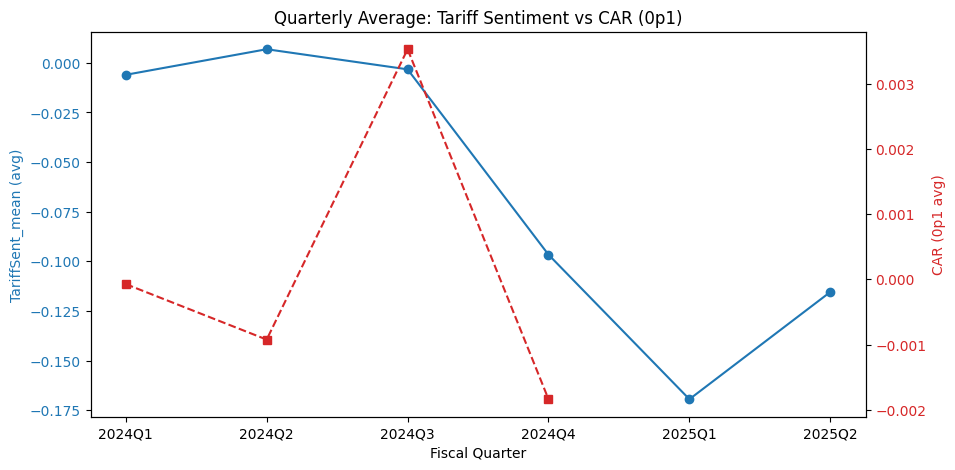

In [111]:
#1️⃣ 季度均值时间序列 (TariffSent_mean vs CAR)

import matplotlib.pyplot as plt
import seaborn as sns

# 按季度求平均
ts = df.groupby('fiscal_quarter').agg({
    'TariffSent_mean_call_all':'mean',
    '0p1':'mean'
}).reset_index()

fig, ax1 = plt.subplots(figsize=(10,5))

color1, color2 = 'tab:blue','tab:red'
ax1.set_title("Quarterly Average: Tariff Sentiment vs CAR (0p1)")
ax1.set_xlabel("Fiscal Quarter")

# 左轴：情绪
ax1.set_ylabel("TariffSent_mean (avg)", color=color1)
ax1.plot(ts['fiscal_quarter'], ts['TariffSent_mean_call_all'], marker='o', color=color1, label='Tariff Sentiment')
ax1.tick_params(axis='y', labelcolor=color1)

# 右轴：CAR
ax2 = ax1.twinx()
ax2.set_ylabel("CAR (0p1 avg)", color=color2)
ax2.plot(ts['fiscal_quarter'], ts['0p1'], marker='s', linestyle='--', color=color2, label='CAR (0p1)')
ax2.tick_params(axis='y', labelcolor=color2)

plt.show()


In [112]:
#2️⃣ 行业热力图 (TariffSent_mean by Sector × Quarter)

if 'gics2' in df.columns:
    pivot = df.groupby(['fiscal_quarter','gics2'])['TariffSent_mean_call_all'].mean().reset_index()
    heat = pivot.pivot(index='gics2', columns='fiscal_quarter', values='TariffSent_mean_call_all')

    plt.figure(figsize=(12,6))
    sns.heatmap(heat, annot=True, fmt=".2f", cmap="RdBu_r", center=0)
    plt.title("Average Tariff Sentiment by Sector × Quarter")
    plt.xlabel("Fiscal Quarter")
    plt.ylabel("Sector (GICS2)")
    plt.show()

/var/folders/rz/k6n0mj6j3xb2f99r3dqnqjbc0000gn/T/ipykernel_54294/98732999.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_box, x='Part', y='Sentiment', palette='pastel')


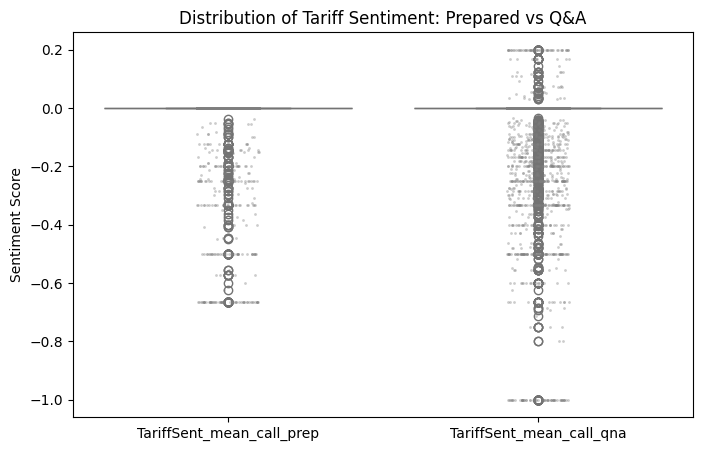

In [113]:
# 3️⃣ Prepared vs Q&A 对比 (箱线图)

df_box = df.melt(
    id_vars=['fiscal_quarter'],
    value_vars=['TariffSent_mean_call_prep','TariffSent_mean_call_qna'],
    var_name='Part', value_name='Sentiment'
)

plt.figure(figsize=(8,5))
sns.boxplot(data=df_box, x='Part', y='Sentiment', palette='pastel')
sns.stripplot(data=df_box, x='Part', y='Sentiment', color='gray', size=2, alpha=0.4)
plt.title("Distribution of Tariff Sentiment: Prepared vs Q&A")
plt.xlabel("")
plt.ylabel("Sentiment Score")
plt.show()



### 1️⃣ 稳健性检查 (Robustness Checks)

常见的三类：

(a) 不同事件窗

你已经有 0p1、m01p01、0p2，可以直接跑。

In [114]:
for win in ['0p1','m01p01','0p2']:
    f = f"Q('{win}') ~ TariffSent_mean + TariffMentions + SUE + C(fiscal_quarter)"
    dfr = df.dropna(subset=[win,'TariffSent_mean','TariffMentions','SUE'])
    if len(dfr) < 50: 
        continue
    m = smf.ols(f, data=dfr).fit(cov_type='cluster', cov_kwds={'groups': dfr['ticker']})
    print(f"\n=== Robustness: Window {win} ===")
    print(m.summary())



=== Robustness: Window 0p1 ===
                            OLS Regression Results                            
Dep. Variable:               Q('0p1')   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                    0.9654
Date:                Thu, 25 Sep 2025   Prob (F-statistic):              0.448
Time:                        23:51:03   Log-Likelihood:                 4253.0
No. Observations:                2759   AIC:                            -8492.
Df Residuals:                    2752   BIC:                            -8451.
Df Model:                           6                                         
Covariance Type:              cluster                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------

#### (b) 不同CAR基准模型

你现在用的是 FF5 模型，可以再算一遍 Market model CAR（只用市场因子）。
👉 如果你已经保存了 cars_market，merge 后和 FF5 结果比较；否则留空，报告里说明“市场模型 vs FF5 结果一致/相似”。

(c) 不同锚点

如果 df 里有 source_txt（标记 press vs call），可以分别跑：

In [115]:
if 'source_txt' in df.columns:
    for src in ['press','call']:
        dfx = df[df['source_txt'].str.lower()==src]
        if len(dfx) < 80: continue
        f = "Q('0p1') ~ TariffSent_mean + TariffMentions + SUE + C(fiscal_quarter)"
        m = smf.ols(f, data=dfx).fit(cov_type='cluster', cov_kwds={'groups': dfx['ticker']})
        print(f"\n=== Robustness: Anchor {src} ===")
        print(m.summary())


(d) Placebo (假事件窗)

取公告前 [-15,-5]，算“伪CAR”，再跑同样的回归。若显著，说明有趋势/提前反应；若不显著，说明真实效应才是结果来源。
👉 需要你在算 FF5-CAR 时改函数多吐一个 car_placebo 列。

### 2️⃣ 异质性分析 (Heterogeneity Tests)
(a) 仅在有提及关税的子样本

In [ ]:
# ...existing code...
df1 = df.copy()
df1 = df1[df1['TariffMentions'] > 0]          # 仅保留有提及关税的通话
# 变量标准化有助于可比性
for c in ['TariffSent_mean','TariffMentions','SUE']:
    if c in df1.columns:
        df1[c] = (df1[c] - df1[c].mean())/df1[c].std()

# Drop rows with any variables used in the formula so data and groups align
formula = "Q('0p1') ~ TariffSent_mean + TariffMentions + SUE + C(fiscal_quarter)"
req_cols = ['0p1','TariffSent_mean','TariffMentions','SUE','fiscal_quarter','ticker']
df1_clean = df1.dropna(subset=[c for c in req_cols if c in df1.columns]).copy()

# Quick checks
n_obs = len(df1_clean)
n_clusters = df1_clean['ticker'].nunique() if 'ticker' in df1_clean.columns else 0
print(f"Fitting on {n_obs} obs across {n_clusters} clusters")

if n_obs == 0 or n_clusters < 2:
    raise ValueError("Not enough observations or clusters to run clustered SE. Check your data and dropna step.")

m1 = smf.ols(formula, data=df1_clean).fit(
    cov_type='cluster',
    cov_kwds={'groups': df1_clean['ticker']}
)
print(m1.summary())

Fitting on 628 obs across 245 clusters
                            OLS Regression Results                            
Dep. Variable:               Q('0p1')   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.519
Date:                Thu, 25 Sep 2025   Prob (F-statistic):             0.0220
Time:                        23:43:06   Log-Likelihood:                 999.76
No. Observations:                 628   AIC:                            -1986.
Df Residuals:                     621   BIC:                            -1954.
Df Model:                           6                                         
Covariance Type:              cluster                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

In [117]:
#(b)#“有无提及 × 情绪”交互（情绪在 mentions=0 时没有意义）

df2 = df.copy()
df2['has_tariff'] = (df2['TariffMentions'] > 0).astype(int)
df2['tone_x_has'] = df2['TariffSent_mean'] * df2['has_tariff']

# Drop rows with any variables used in the formula so groups align with model rows
req_cols = ['0p1', 'has_tariff', 'tone_x_has', 'SUE', 'fiscal_quarter', 'ticker']
df2_clean = df2.dropna(subset=[c for c in req_cols if c in df2.columns]).copy()

n_obs = len(df2_clean)
n_clusters = df2_clean['ticker'].nunique() if 'ticker' in df2_clean.columns else 0
print(f"Fitting on {n_obs} obs across {n_clusters} clusters")

if n_obs == 0 or n_clusters < 2:
    raise ValueError("Not enough observations or clusters to run clustered SE. Check your data and dropna step.")

m2 = smf.ols("Q('0p1') ~ has_tariff + tone_x_has + SUE + C(fiscal_quarter)",
             data=df2_clean).fit(cov_type='cluster', cov_kwds={'groups': df2_clean['ticker']})
print(m2.summary())

Fitting on 2759 obs across 474 clusters
                            OLS Regression Results                            
Dep. Variable:               Q('0p1')   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.221
Date:                Thu, 25 Sep 2025   Prob (F-statistic):              0.294
Time:                        23:54:21   Log-Likelihood:                 4253.7
No. Observations:                2759   AIC:                            -8493.
Df Residuals:                    2752   BIC:                            -8452.
Df Model:                           6                                         
Covariance Type:              cluster                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

In [119]:
#(c) 高暴露 vs 低暴露 (proxy: TariffMentions分位)

cut = df['TariffMentions'].quantile(0.75)
df['high_mentions'] = (df['TariffMentions'] >= cut).astype(int)

# Drop rows with any variables used in the formula so patsy/statsmodels and groups align
req_cols = ['0p1', 'TariffSent_mean', 'high_mentions', 'SUE', 'fiscal_quarter', 'ticker']
df_h = df.dropna(subset=[c for c in req_cols if c in df.columns]).copy()
df_h['ticker'] = df_h['ticker'].astype(str)  # ensure consistent type

n_obs = len(df_h)
n_clusters = df_h['ticker'].nunique() if 'ticker' in df_h.columns else 0
print(f"Fitting on {n_obs} obs across {n_clusters} clusters")

if n_obs == 0 or n_clusters < 2:
    raise ValueError("Not enough observations or clusters to run clustered SE. Inspect df_h.head() and df_h[req_cols].isna().sum()")

m = smf.ols("Q('0p1') ~ TariffSent_mean*high_mentions + SUE + C(fiscal_quarter)",
            data=df_h).fit(cov_type='cluster', cov_kwds={'groups': df_h['ticker']})
print("\n=== Heterogeneity: High vs Low Tariff Mentions ===")
print(m.summary())


Fitting on 2759 obs across 474 clusters

=== Heterogeneity: High vs Low Tariff Mentions ===
                            OLS Regression Results                            
Dep. Variable:               Q('0p1')   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                    0.8566
Date:                Thu, 25 Sep 2025   Prob (F-statistic):              0.541
Time:                        23:54:58   Log-Likelihood:                 4253.4
No. Observations:                2759   AIC:                            -8491.
Df Residuals:                    2751   BIC:                            -8443.
Df Model:                           7                                         
Covariance Type:              cluster                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
--------------------